In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
warnings.simplefilter('ignore')

In [4]:
data = pd.read_csv('subscription.csv', parse_dates= ['subscription_signup_date'])

In [5]:
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,2015-01-01,29,Spain,ads,4,0
1,12474,2015-01-01,49,France,ads,5,0
2,12294,2015-01-01,49,Germany,ads,2,0
3,3878,2015-01-01,49,China,ads,1,0
4,9567,2015-01-01,49,UK,ads,5,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   user_id                    500000 non-null  int64         
 1   subscription_signup_date   500000 non-null  datetime64[ns]
 2   subscription_monthly_cost  500000 non-null  int64         
 3   country                    500000 non-null  object        
 4   source                     500000 non-null  object        
 5   billing_cycles             500000 non-null  int64         
 6   is_active                  500000 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 26.7+ MB


# A model that predicts monthly retention rate for the different subscription price points

In [7]:
data['subscription_monthly_cost'].value_counts()

49    300397
29    146362
99     53241
Name: subscription_monthly_cost, dtype: int64

In [15]:
data['billing_cycles'].value_counts()

1    287374
2     79838
8     49999
3     35198
4     19753
5     12631
6      8767
7      6440
Name: billing_cycles, dtype: int64

In [34]:
def retention_rate(df):
    total_user = len(df)
    rate = []
    for i in df['billing_cycles'].value_counts().keys().tolist():
        rate.append(len(df[df['billing_cycles'] == i])/total_user)
    return pd.Series(rate, index=[1, 2, 3, 4, 5, 6, 7, 8])

In [36]:
grouped = data.groupby('subscription_monthly_cost').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,0.392458,0.235901,0.149069,0.082241,0.053204,0.037612,0.028259,0.021256
49,0.616334,0.177419,0.072204,0.048845,0.037577,0.022394,0.014664,0.010563
99,0.841231,0.088729,0.027629,0.015007,0.012735,0.007494,0.004245,0.002930


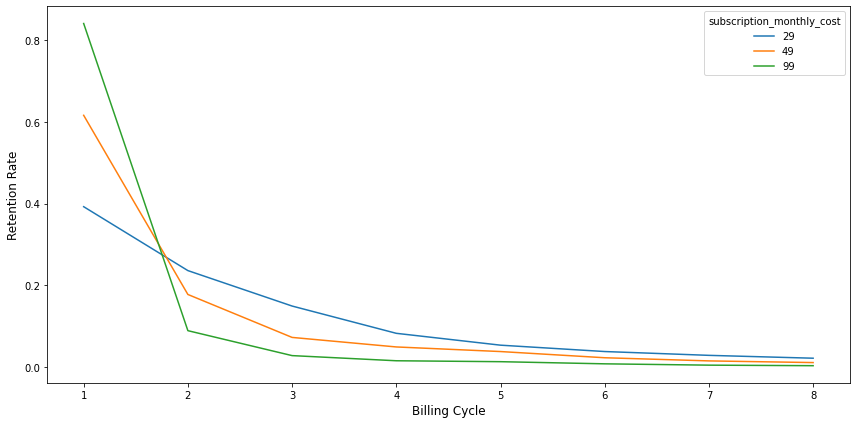

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped.T.plot(kind='line', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
plt.tight_layout()
plt.show()

In [50]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
x2 = x ** 2
logx = np.log(x)

array([ 1,  4,  9, 16, 25, 36, 49, 64])

In [51]:
rate_29 = grouped.loc[29].values
rate_49 = grouped.loc[49].values
rate_99 = grouped.loc[99].values

In [53]:
features = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx, 'y_29': rate_29, 'y_49': rate_49, 'y_99': rate_99}, 
                        columns=['x', 'x2', 'logx', 'y_29', 'y_49', 'y_99'])

In [54]:
features

,x,x2,logx,y_29,y_49,y_99
0,1,1,0.000000,0.392458,0.616334,0.841231
1,2,4,0.693147,0.235901,0.177419,0.088729
2,3,9,1.098612,0.149069,0.072204,0.027629
3,4,16,1.386294,0.082241,0.048845,0.015007
4,5,25,1.609438,0.053204,0.037577,0.012735
5,6,36,1.791759,0.037612,0.022394,0.007494
6,7,49,1.945910,0.028259,0.014664,0.004245
7,8,64,2.079442,0.021256,0.010563,0.002930


In [56]:
model_29 = LinearRegression()
model_49 = LinearRegression()
model_99 = LinearRegression()

model_29 = model_29.fit(features[['x', 'x2', 'logx']], np.log(features['y_29']))
model_49 = model_49.fit(features[['x', 'x2', 'logx']], np.log(features['y_49']))
model_99 = model_99.fit(features[['x', 'x2', 'logx']], np.log(features['y_99']))

Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

In [57]:
# make prediction
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
x2 = x ** 2
logx = np.log(x)

pred = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx}, columns=['x', 'x2', 'logx'])
pred['pred_29'] = np.exp(model_29.predict(pred[['x', 'x2', 'logx']]))
pred['pred_49'] = np.exp(model_49.predict(pred[['x', 'x2', 'logx']]))
pred['pred_99'] = np.exp(model_99.predict(pred[['x', 'x2', 'logx']]))

pred

,x,x2,logx,pred_29,pred_49,pred_99
0,1,1,0.000000,0.391815,0.625785,0.855447
1,2,4,0.693147,0.240732,0.163309,0.081870
2,3,9,1.098612,0.141082,0.080948,0.029711
3,4,16,1.386294,0.085290,0.049827,0.016654
4,5,25,1.609438,0.054510,0.033338,0.010881
5,6,36,1.791759,0.037234,0.022850,0.007311
6,7,49,1.945910,0.027342,0.015544,0.004724
7,8,64,2.079442,0.021660,0.010298,0.002821
8,9,81,2.197225,0.018552,0.006564,0.001517
9,10,100,2.302585,0.017207,0.003992,0.000722


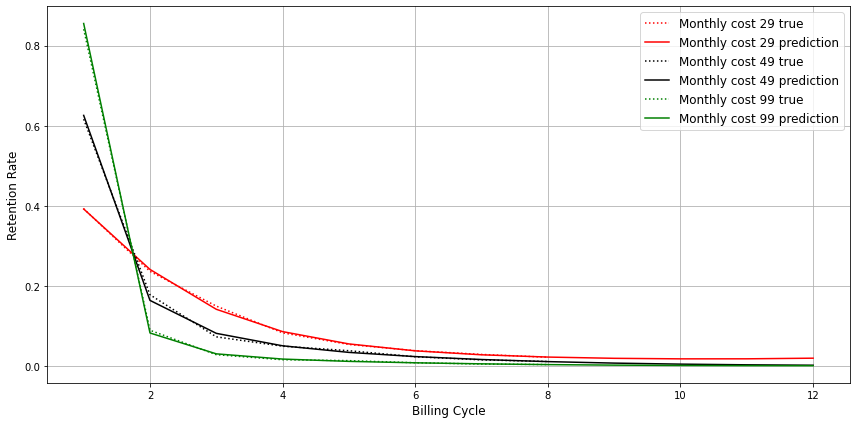

In [60]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(features['x'], features['y_29'], 'r:', label='Monthly cost 29 true')
ax.plot(pred['x'], pred['pred_29'], 'r-', label='Monthly cost 29 prediction')
ax.plot(features['x'], features['y_49'], 'k:', label='Monthly cost 49 true')
ax.plot(pred['x'], pred['pred_49'], 'k-', label='Monthly cost 49 prediction')
ax.plot(features['x'], features['y_99'], 'g:', label='Monthly cost 99 true')
ax.plot(pred['x'], pred['pred_99'], 'g-', label='Monthly cost 99 prediction')
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

# Influence of Country

In [61]:
# calculate the retention rate for each montly cost
grouped = data.groupby('country').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
country,,,,,,,,
China,0.485169,0.295453,0.112054,0.042351,0.024153,0.016417,0.012772,0.011631
France,0.665054,0.157214,0.058728,0.049688,0.030525,0.018544,0.011595,0.008652
Germany,0.548716,0.172873,0.082501,0.078465,0.049436,0.031323,0.021283,0.015403
India,0.553272,0.225769,0.119766,0.042434,0.022925,0.014867,0.011889,0.009078
Italy,0.658316,0.162182,0.059588,0.048695,0.029899,0.018879,0.013612,0.008829
Spain,0.660902,0.160113,0.059106,0.048503,0.031231,0.018583,0.012448,0.009114
UK,0.541062,0.173804,0.087067,0.079494,0.048646,0.032065,0.021621,0.016241
US,0.543491,0.172254,0.085402,0.078981,0.049569,0.031887,0.022522,0.015894


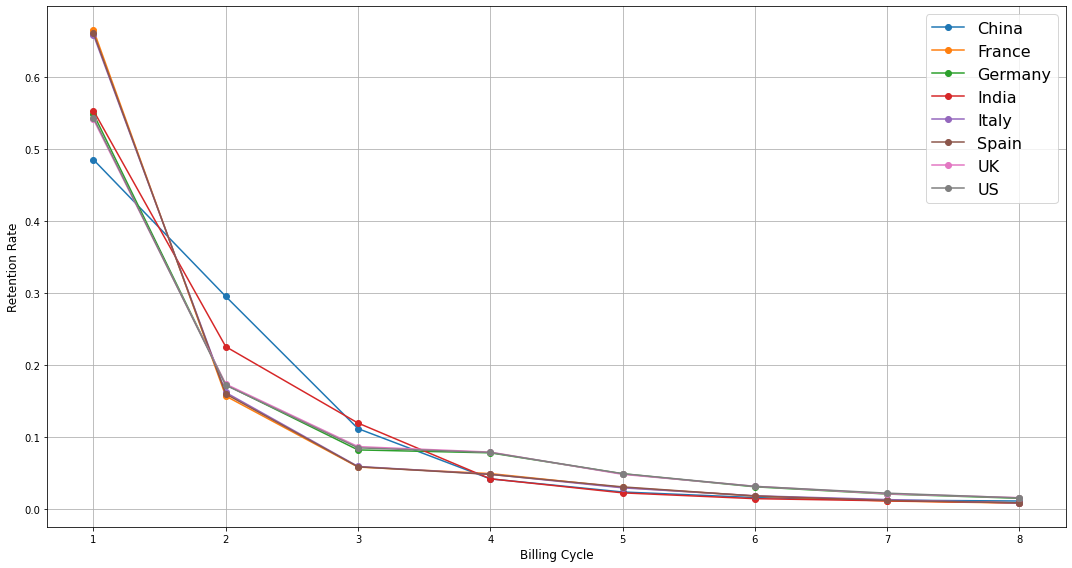

In [62]:
fig, ax = plt.subplots(figsize=(15, 8))
grouped.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

# Influence of Source

In [64]:
# calculate the retention rate for each montly cost
grouped = data.groupby('source').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
source,,,,,,,,
ads,0.611127,0.166780,0.069486,0.066237,0.037648,0.022916,0.015287,0.010519
friend_referral,0.436507,0.300557,0.082405,0.055756,0.041428,0.032258,0.026486,0.024603
seo,0.437605,0.194475,0.142383,0.082418,0.051340,0.038378,0.029197,0.024205


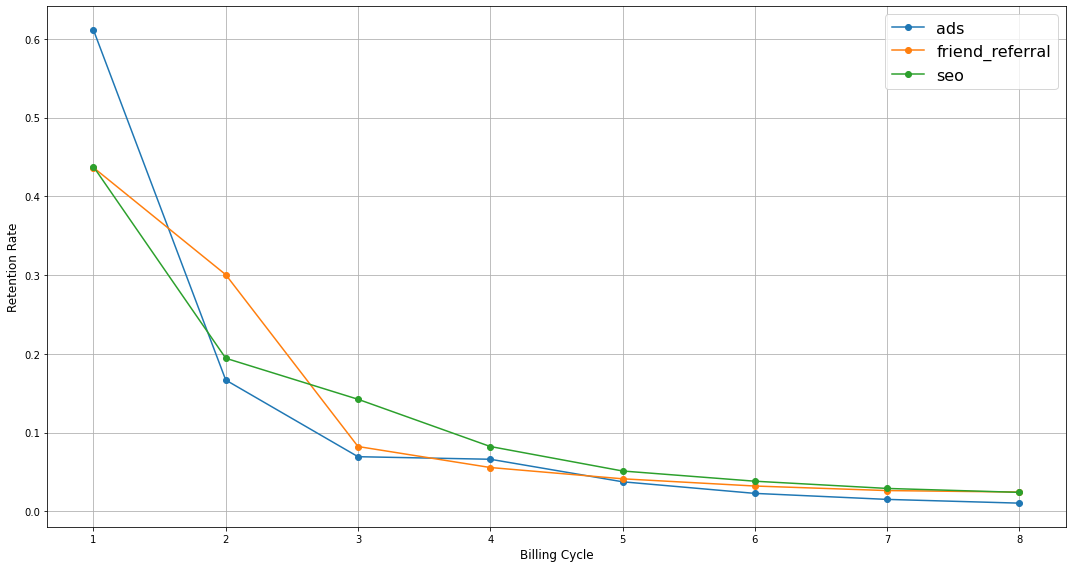

In [65]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
grouped.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()